# Tutorial 2 - Hydrous Melting
Simon Matthews (University of Iceland), Matthew Gleeson (University of Cardiff), Kevin Wong (University of Leeds)

## Introduction
The lithology objects defined in pyMelt are all anhydrous; however, pyMelt can extend any of these models (and other user defined models) to incorporate the effects of water. We use and extend the formulation set out by Katz et al. (2003), where the solidus temperature is reduced by:

$$
\Delta T(X_{H2O}) = K X^\gamma_{H2O}, \qquad 0 < \gamma < 1
$$

(Eqn. 16 from Katz et al., 2003). $X_{H2O}$ is the melt H$_2$O content in wt%, and $K$ and $\gamma$ are fitted parameters. The value of $X_{H2O}$ is set either by batch melting (as done by Katz et al., 2003):

$$
X_{H2O} = \frac{X_{H2O}^{bulk}}{D_{H2O} + F (1 - D_{H2O})}
$$

or by continuous melting (i.e., near-fractional melting):

$$
X_{H2O} = \frac{X_{H2O}^{bulk}}{(1-\phi)D + \phi} (1-F)^\frac{(1-\phi)(1-D)}{(1-\phi)D+\phi}
$$

in both equations $D$ is the partition coefficient of H$_2$O between solid and melt. Additionally, the continous melting equation also requires a value to be set for the porosity $\phi$, which is the fraction of melt retained and not fractionated. 

Note that when using the continuous melting equation it is necessarily not entirely self consistent with the existing melting formulation. The lithology calibrations and the melting equations assume batch melting. However, in most practical applications we make the assumption that this is a close approximation to the melting behaviour of the same lithology during fractional melting. This is clearly not true when water is included- extraction of water will reduce the effect of incorporating water. It is for this reason that modelling water in this manner is still useful.

Katz et al. (2003) limit the amount of water that can enter the melt by imposing a pressure dependent saturation limit. We implement the same equation in pyMelt.

The final modification to the melting equations concerns the calculation of the melt fraction. To calculate $\Delta T(X_{H2O})$ the value of $X_{H2O}$ (the water content in the melt) must be known. To calculate $X_{H2O}$ the melt fraction is required. There is, therefore, no simple expression to calculate $F$ given all the known parameters. Instead, $F$ must be found by picking a value, calculating the $X_{H2O}$ and $F$ this value imply, and iterating until the picked value of $F$ matches the value calculated.

First, pyMelt must be imported, and other useful packages, must be imported:

In [1]:
import pyMelt
import numpy as np
import matplotlib.pyplot as plt

## The hydrous lithology object
The first step is to create a new hydrous lithology object from an anhydrous lithology object. This new object inherits all of the melting behaviour, but with the addition of the above equations (and a suitably adjusted solidus and melt-fraction). We must also specify its H$_2$O content in wt%. In this case we will create a lithology with 0.1 wt% H$_2$O, and one with 0.2 wt% H$_2$O.

To create a hydrated lithology:

In [2]:
# Create an anhydrous lithology object:
lz = pyMelt.lithologies.matthews.klb1()
# Create a hydrated lithology from it:
hlz = pyMelt.hydrous_lithology(lz, H2O=0.1)
hhlz = pyMelt.hydrous_lithology(lz, H2O=0.2)

### Solidus position
We can calculate the new solidii and compare with the anhydrous solidus:

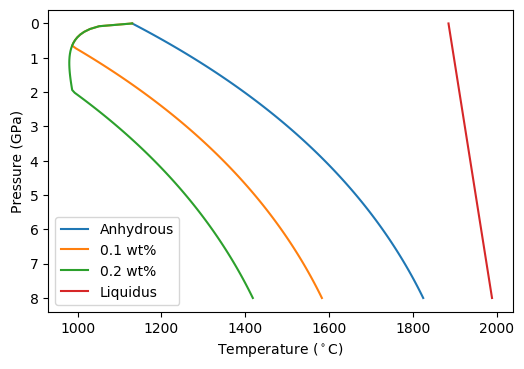

In [3]:
p = np.linspace(0,8.0,100)
t = np.zeros([len(p),4])
for i in range(len(p)):
    t[i,0] = lz.TSolidus(p[i])
    t[i,1] = hlz.TSolidus(p[i])
    t[i,2] = hhlz.TSolidus(p[i])
    t[i,3] = lz.TLiquidus(p[i])

f,a = plt.subplots(dpi=100)
a.plot(t[:,0], p, label='Anhydrous')
a.plot(t[:,1], p, label='0.1 wt%')
a.plot(t[:,2], p, label='0.2 wt%')
a.plot(t[:,3], p, label='Liquidus')
a.set_xlabel('Temperature ($^\circ$C)')
a.set_ylabel('Pressure (GPa)')
a.invert_yaxis()
a.legend()

plt.show()

The figure shows that the solidus is deplaced to lower temperature by the addition of H$_2$O, as expected. The liquidus does not change (try changing the calculation above to calculate the liquidus curve from one of the hydrated lithologies). The uptick in solidus temperature at low temperature is due to the limit of H2O saturation in the melt- at lower pressures a vapour phase will become stable in preference to forming a melt.

### Melting behaviour (isobaric)
We can also calculate the melt fraction at fixed pressure, in a similar way:

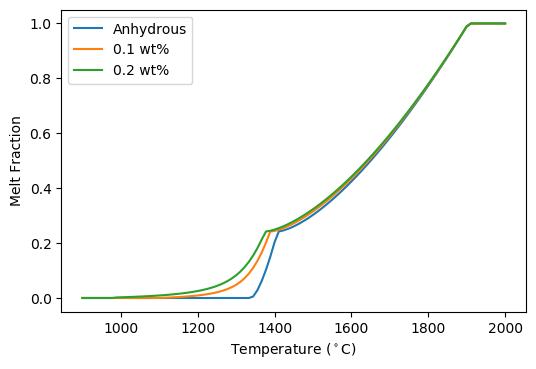

In [4]:
t = np.linspace(900, 2000, 100)
p = 1.5
mf = np.zeros([len(t),4])
for i in range(len(t)):
    mf[i,0] = lz.F(p, t[i])
    mf[i,1] = hlz.F(p, t[i])
    mf[i,2] = hhlz.F(p, t[i])

f,a = plt.subplots(dpi=100)
a.plot(t, mf[:,0], label='Anhydrous')
a.plot(t, mf[:,1], label='0.1 wt%')
a.plot(t, mf[:,2], label='0.2 wt%')
a.set_xlabel('Temperature ($^\circ$C)')
a.set_ylabel('Melt Fraction')
a.legend()

plt.show()

When we defined the lithology objects we didn't specify which of the two equations for $X_{H2O}$ should be used. In this case pyMelt will default to the batch melting equation. We can see how continuous-melting would compare by defining new lithology objects, with different choices for the parameter $\phi$ (the porosity):

In [5]:
hlz005 = pyMelt.hydrous_lithology(lz, 0.1, continuous=True)
hlz001 = pyMelt.hydrous_lithology(lz, 0.1, continuous=True, phi=0.001)
hlz01 = pyMelt.hydrous_lithology(lz, 0.1, continuous=True, phi=0.01)

And now we can compare the 0.1 wt% melt fraction for both batch and continuous melting regimes:

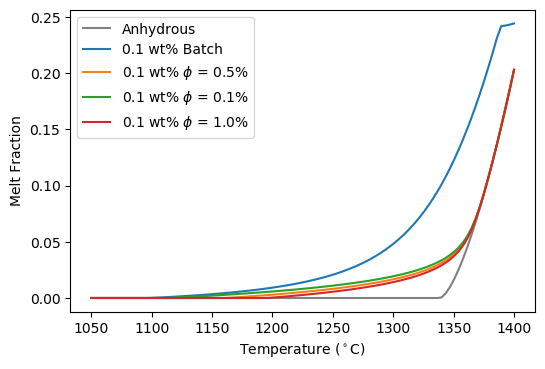

In [6]:
t = np.linspace(1050, 1400, 100)
p = 1.5
mf = np.zeros([len(t),5])
for i in range(len(t)):
    mf[i,0] = lz.F(p, t[i])
    mf[i,1] = hlz.F(p, t[i])
    mf[i,2] = hlz005.F(p, t[i])
    mf[i,3] = hlz001.F(p, t[i])
    mf[i,4] = hlz01.F(p, t[i])

f,a = plt.subplots(dpi=100)
a.plot(t, mf[:,0], label='Anhydrous', c='0.5')
a.plot(t, mf[:,1], label='0.1 wt% Batch')
a.plot(t, mf[:,2], label='0.1 wt% $\phi$ = 0.5%')
a.plot(t, mf[:,3], label='0.1 wt% $\phi$ = 0.1%')
a.plot(t, mf[:,4], label='0.1 wt% $\phi$ = 1.0%')
a.set_xlabel('Temperature ($^\circ$C)')
a.set_ylabel('Melt Fraction')
a.legend()

plt.show()

Batch vs Continuous makes a very large difference, with the choice of $\phi$ having a much more minor effect.

### Pyroxenites
Just as for the lherzolitic lithology used above, pyMelt offers the opportunity to perform hydrous melting with the pyroxenitic lithologies. Caution must be observed; the formulation by Katz et al. (2003) calibrates the parameters based on hydrous lherzolite melting experiments, adjustment may be required before they are applied to hydrous pyroxenite melting.

## Adiabatic Melting
To calculate the melting behaviour of adiabatically decompressing mantle the hydrous lithologies can be treated identically to regular pyMelt lithologies. This means they can form a component of a heterogeneous mantle. Here we will instead consider a pure lithology mantle for the purposes of illustrating the behaviour of the hydrous lithology.

We will use the hydrated lithologies created above to create `pyMelt.Mantle` objects:

In [7]:
m = pyMelt.Mantle([lz], [1.0])
hm = pyMelt.Mantle([hlz], [1.0])
hhm = pyMelt.Mantle([hhlz], [1.0])
hm005 = pyMelt.Mantle([hlz005], [1.0])

hhlz005 = pyMelt.hydrous_lithology(lz, 0.2, continuous=True)
hhm005 = pyMelt.Mantle([hhlz005], [1.0])

Now run the adiabtic melting calculation for each of these `Mantle` objects:

In [8]:
c = m.AdiabaticMelt(1350.0,steps=501)
# hc = hm.AdiabaticMelt(1350.0)
# hhc = hhm.AdiabaticMelt(1350.0)
# hc005 = hm005.AdiabaticMelt(1350.0)
# hhc005 = hhm005.AdiabaticMelt(1350.0)

Note that the hydrous lithologies report a super-solidus start. To avoid this the pressure could be increased; however, it is unlikely that the melt fraction is large at the start of the calculation.

NameError: name 'hc' is not defined

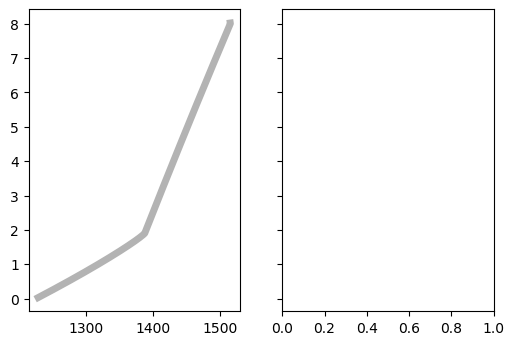

In [9]:
f,a = plt.subplots(1, 2, dpi=100, sharey='row')

a[0].plot(c.T, c.P, label='Anhydrous', c='0.7', lw=5)
a[0].plot(hc.T, hc.P, label='0.1 wt%, batch', c='C1')
a[0].plot(hhc.T, hhc.P, label='0.2 wt%, batch', c='C3')
a[0].plot(hc005.T, hc005.P, label='0.1 wt%, cont.', c='C1', ls='--')
a[0].plot(hhc005.T, hhc005.P, label='0.2 wt%, cont.', c='C3', ls='--')

a[1].plot(c.F, c.P, label='Anhydrous', c='0.7', lw=5)
a[1].plot(hc.F, hc.P, label='0.1 wt%, batch', c='C1')
a[1].plot(hhc.F, hhc.P, label='0.2 wt%, batch', c='C3')
a[1].plot(hc005.F, hc005.P, label='0.1 wt%, cont.', c='C1', ls='--')
a[1].plot(hhc005.F, hhc005.P, label='0.2 wt%, cont.', c='C3', ls='--')

a[0].set_xlabel('Temperature ($^\circ$C)')
a[1].set_xlabel('F')
a[0].set_ylabel('Pressure (GPa)')
a[0].invert_yaxis()
a[1].legend()
plt.show()

As expected, all hydrous models have a low-F melting tail. However, the batch and continuous melting behaviour diverges. For batch melting, an increase in melt fraction persists at most pressures, but for continuous melting the effect rapidly subsides as H$_2$O is removed from the system. We can see this effect in the crustal thicknesses calculated by integrating the melting columns:

In [10]:
morb = pyMelt.geosettings.SpreadingCentre(c, steps=10001)
print("Anhydrous: {:.1f} km".format(morb.tc))
# morb = pyMelt.geosettings.SpreadingCentre(hc)
# print("Batch 0.1 wt%: {:.1f} km".format(morb.tc))
# morb = pyMelt.geosettings.SpreadingCentre(hhc)
# print("Batch 0.2 wt%: {:.1f} km".format(morb.tc))
# morb = pyMelt.geosettings.SpreadingCentre(hc005)
# print("Cont. 0.1 wt%: {:.1f} km".format(morb.tc))
# morb = pyMelt.geosettings.SpreadingCentre(hhc005)
# print("Cont. 0.2 wt%: {:.1f} km".format(morb.tc))

Anhydrous: 6.3 km


In [23]:
m = pyMelt.Mantle([lz], [1.0])
steps = np.logspace(2,4.5,10) 
steps_tc = np.logspace(2,5,4) 
tc = np.zeros([np.shape(steps)[0],np.shape(steps_tc)[0]])
for i in range(len(steps)):
    cc = m.AdiabaticMelt(1350.0,steps=int(steps[i]))
    for j in range(len(steps_tc)):
        morb = pyMelt.geosettings.SpreadingCentre(cc, steps=int(steps_tc[j]))
        tc[i,j] = morb.tc

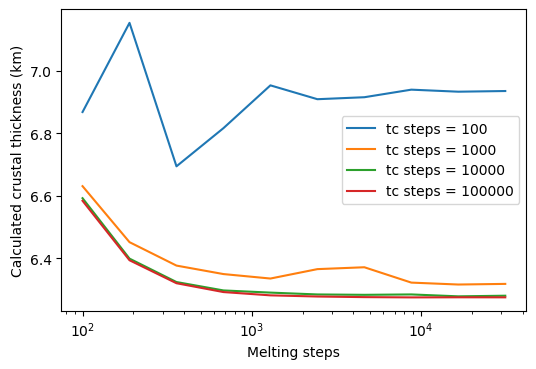

In [24]:
f, a = plt.subplots(dpi=100)
for i in range(len(steps_tc)):
    a.plot(steps,tc[:,i], label="tc steps = " + str(int(steps_tc[i])))
a.set_xscale('log')
a.set_xlabel("Melting steps")
a.set_ylabel("Calculated crustal thickness (km)")
a.legend()
plt.show()

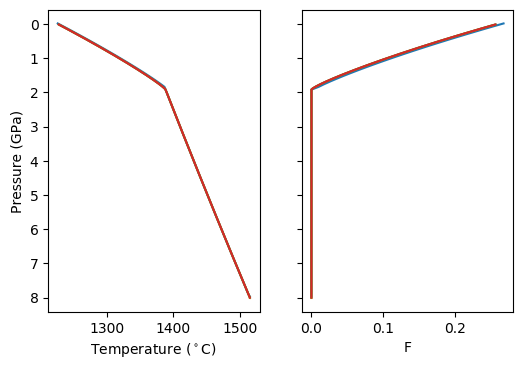

In [16]:
f,a = plt.subplots(1, 2, dpi=100, sharey='row')

for i in range(len(steps)):
    a[0].plot(c[i].T, c[i].P)

    a[1].plot(c[i].F, c[i].P)
    
a[0].set_xlabel('Temperature ($^\circ$C)')
a[1].set_xlabel('F')
a[0].set_ylabel('Pressure (GPa)')
a[0].invert_yaxis()
# a[1].legend()
plt.show()

The increase in crustal thickness due to the presence of H$_2$O is much more modest for the continuous melting model.

## Adiabatic melting of a 2-component mantle

Multi-component mantle: 6.5 km


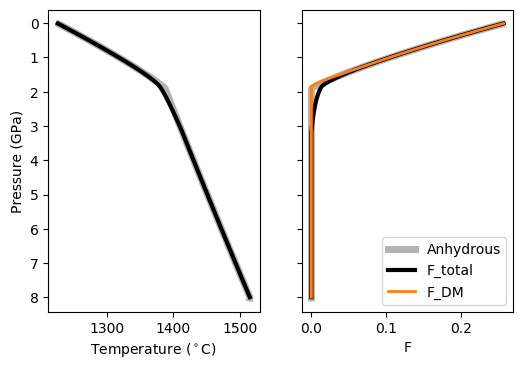

In [12]:
# Create a hydrated lithology from it
DM = pyMelt.hydrous_lithology(lz, H2O = 0.0, continuous=True)
# lz2 = pyMelt.lithologies.matthews.klb1()
EM = pyMelt.hydrous_lithology(lz, H2O = 0.05, continuous=True, set_zero=1e-10)
px = pyMelt.lithologies.matthews.kg1()

m_multi = pyMelt.Mantle([DM, EM], [1.0,1.1],['DM','EM']) # same results are seen if lz is used in place of DM

c_multi = m_multi.AdiabaticMelt(1350.0)

morb = pyMelt.geosettings.SpreadingCentre(c_multi)
print("Multi-component mantle: {:.1f} km".format(morb.tc))

f,a = plt.subplots(1, 2, dpi=100, sharey='row')

a[0].plot(c.T, c.P, label='Anhydrous', c='0.7', lw=5)
a[0].plot(c_multi.T, c_multi.P, label='P-T path', c='0', lw=3)

a[1].plot(c.F, c.P, label='Anhydrous', c='0.7', lw=5)
a[1].plot(c_multi.F, c_multi.P, label='F_total', c='0', lw=3)
a[1].plot(c_multi.lithologies['DM'].F, c_multi.P, label='F_DM', c='C1', lw=2)

# a[0].set_xlim(1380,1395)
# a[0].set_ylim(1.8,1.9)

a[0].set_xlabel('Temperature ($^\circ$C)')
a[1].set_xlabel('F')
a[0].set_ylabel('Pressure (GPa)')
a[0].invert_yaxis()
a[1].legend()
plt.show()

## Influence of source proportions on crustal thickness

Note the bumps in the crustal thickness curves below. This is where the Tolerance issue is occurring and I believe F isn't converging, but scipy is still outputting a value that pymelt then carries forward.

/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/pyMelt/lithology_classes.py:259: RuntimeWarning: invalid value encountered in double_scalars
  return self.chi1 * P ** self.l + self.chi2 * P


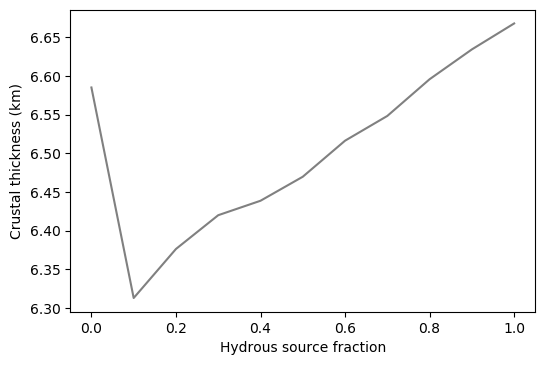

In [25]:
x=np.linspace(0.0,1.0,11)
tc_r=np.zeros(len(x))

for i in range(len(x)):
    m_multi = pyMelt.Mantle([DM, EM], [1.0-x[i],x[i]],['DM','EM'])

    c_multi = m_multi.AdiabaticMelt(1350.0,steps=101)

    morb = pyMelt.geosettings.SpreadingCentre(c_multi, steps=10001)
    tc_r[i]= morb.tc

f,a = plt.subplots(dpi=100)
a.plot(x, tc_r, c='0.5')
a.set_xlabel('Hydrous source fraction')
a.set_ylabel('Crustal thickness (km)')

plt.show()

In [12]:
m1 = pyMelt.Mantle([DM, EM], [0.8,0.2],['DM','EM'])
c1 = m1.AdiabaticMelt(1350.0,steps=1001)
# m2 = pyMelt.Mantle([DM, EM], [0.85,0.15],['DM','EM'])
# c2 = m2.AdiabaticMelt(1350.0,steps=1001)

/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/zeros.py:343: RuntimeWarning: Tolerance of 0.008746391588829283 reached.
  warnings.warn(msg, RuntimeWarning)
/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/zeros.py:343: RuntimeWarning: Tolerance of 0.007148972947788934 reached.
  warnings.warn(msg, RuntimeWarning)


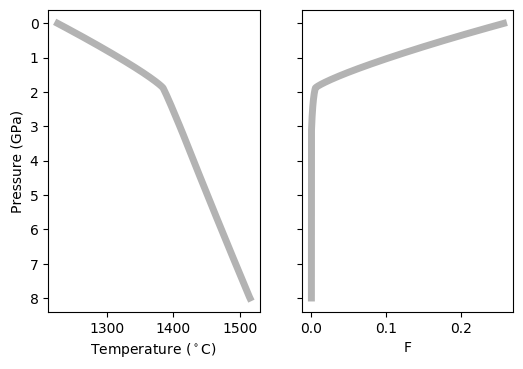

In [13]:
f,a = plt.subplots(1, 2, dpi=100, sharey='row')

a[0].plot(c1.T, c1.P, label='Anhydrous', c='0.7', lw=5)
# a[0].plot(c2.T, c2.P, label='P-T path', c='0', lw=1)

a[1].plot(c1.F, c1.P, label='Anhydrous', c='0.7', lw=5)
# a[1].plot(c2.F, c2.P, label='F_total', c='0', lw=1)

# a[0].set_xlim(1380,1395)
# a[0].set_ylim(1.8,2.1)
# a[1].set_xlim(0,0.01)

a[0].set_xlabel('Temperature ($^\circ$C)')
a[1].set_xlabel('F')
a[0].set_ylabel('Pressure (GPa)')
a[0].invert_yaxis()
# a[1].legend()
plt.show()

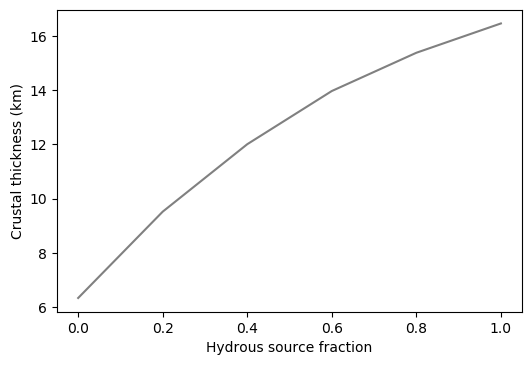

In [14]:
x=np.linspace(0.0,1.0,6)
tc_r=np.zeros(len(x))

for i in range(len(x)):
    m_multi = pyMelt.Mantle([lz, px], [1.0-x[i],x[i]],['DM','EM'])

    c_multi = m_multi.AdiabaticMelt(1350.0,steps=1001)

    morb = pyMelt.meltingcolumn_classes.SpreadingCentre(c_multi)
    tc_r[i]= morb.tc

f,a = plt.subplots(dpi=100)
a.plot(x, tc_r, c='0.5')
a.set_xlabel('Hydrous source fraction')
a.set_ylabel('Crustal thickness (km)')

plt.show()

In [51]:
DM = pyMelt.hydrous_lithology(lz, H2O = 0.0, continuous=True)
EM = pyMelt.hydrous_lithology(lz, H2O = 0.05, continuous=True)

m1 = pyMelt.Mantle([DM, EM], [0.55,0.45],['DM','EM'])
m2 = pyMelt.Mantle([DM, EM], [0.5,0.5],['DM','EM'])
m3 = pyMelt.Mantle([DM, EM], [0.1,0.9],['DM','EM'])

c1 = m1.AdiabaticMelt(1350.0, steps=1001)
c2 = m2.AdiabaticMelt(1350.0, steps=1001)
c3 = m3.AdiabaticMelt(1350.0, steps=1001)

s1 = pyMelt.meltingcolumn_classes.SpreadingCentre(c1)
s2 = pyMelt.meltingcolumn_classes.SpreadingCentre(c2)
s3 = pyMelt.meltingcolumn_classes.SpreadingCentre(c3)

In [52]:
s1.tc

6.534982824280364

In [53]:
s2.tc

6.487717182204433

In [54]:
s3.tc

6.67754407489429

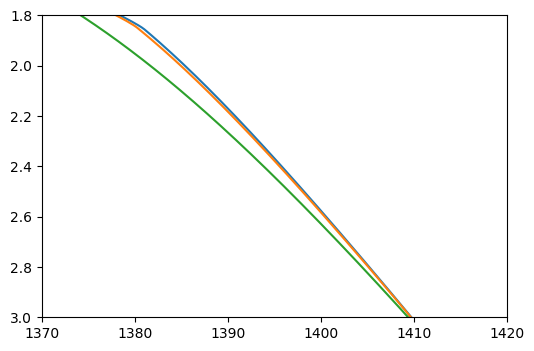

In [55]:
f,a = plt.subplots(dpi=100)
a.plot(c1.T, c1.P)
a.plot(c2.T,c2.P)
a.plot(c3.T,c3.P)
a.set_xlim(1370,1420)
a.set_ylim(1.8,3.0)
a.invert_yaxis()

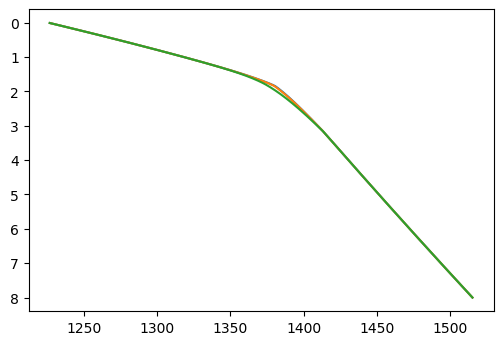

In [56]:
f,a = plt.subplots(dpi=100)
a.plot(c1.T, c1.P)
a.plot(c2.T,c2.P)
a.plot(c3.T,c3.P)
# a.set_xlim(1370,1420)
# a.set_ylim(1.8,3.0)
a.invert_yaxis()

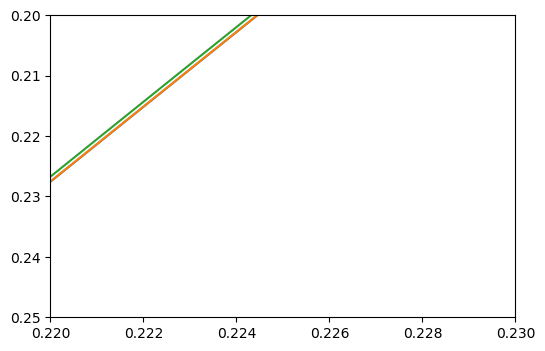

In [64]:
f,a = plt.subplots(dpi=100)
a.plot(c1.F, c1.P)
a.plot(c2.F, c2.P)
a.plot(c3.F, c3.P)
a.set_xlim(0.22,0.23)
a.set_ylim(0.2,0.25)
# a.set_xscale('log')
a.invert_yaxis()

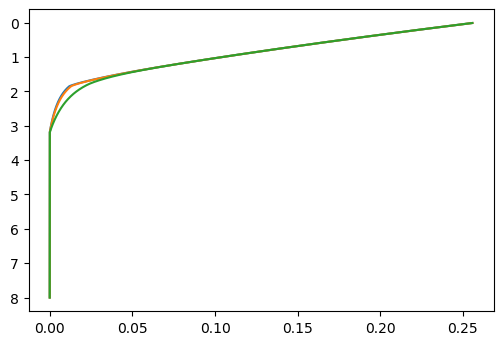

In [58]:
f,a = plt.subplots(dpi=100)
a.plot(c1.F, c1.P)
a.plot(c2.F, c2.P)
a.plot(c3.F, c3.P)
# a.set_xlim(-0.005,0.01)
# a.set_ylim(1.8,3.5)
# a.set_xscale('log')
a.invert_yaxis()

In [49]:
c1.lithologies['EM'].F

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
996     0.250407
997     0.251739
998     0.253072
999     0.254408
1000    0.255745
Name: F, Length: 1001, dtype: float64

In [48]:
c2.lithologies['EM'].F

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
996     0.250398
997     0.251730
998     0.253063
999     0.254399
1000    0.255736
Name: F, Length: 1001, dtype: float64

In [60]:
c3.lithologies['DM'].F

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
996     0.250272
997     0.251604
998     0.252938
999     0.254273
1000    0.255610
Name: F, Length: 1001, dtype: float64

In [32]:
hz = pyMelt.lithologies.shorttle.harzburgite()

In [31]:
np.infmax(np.array([1,2,np.inf]))

AttributeError: module 'numpy' has no attribute 'infmax'

In [33]:
m = pyMelt.Mantle([DM,EM,hz], [1,1,1])

In [34]:
m.solidus_intersection(1400.0)

array([2.49761628, 3.99406524,        nan])

In [24]:
p = np.linspace(0,8,101)
p

array([0.  , 0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 ,
       0.88, 0.96, 1.04, 1.12, 1.2 , 1.28, 1.36, 1.44, 1.52, 1.6 , 1.68,
       1.76, 1.84, 1.92, 2.  , 2.08, 2.16, 2.24, 2.32, 2.4 , 2.48, 2.56,
       2.64, 2.72, 2.8 , 2.88, 2.96, 3.04, 3.12, 3.2 , 3.28, 3.36, 3.44,
       3.52, 3.6 , 3.68, 3.76, 3.84, 3.92, 4.  , 4.08, 4.16, 4.24, 4.32,
       4.4 , 4.48, 4.56, 4.64, 4.72, 4.8 , 4.88, 4.96, 5.04, 5.12, 5.2 ,
       5.28, 5.36, 5.44, 5.52, 5.6 , 5.68, 5.76, 5.84, 5.92, 6.  , 6.08,
       6.16, 6.24, 6.32, 6.4 , 6.48, 6.56, 6.64, 6.72, 6.8 , 6.88, 6.96,
       7.04, 7.12, 7.2 , 7.28, 7.36, 7.44, 7.52, 7.6 , 7.68, 7.76, 7.84,
       7.92, 8.  ])

In [25]:
diff = np.abs(p - m.solidus_intersection(1400.0))
diff

array([2.49761628, 2.41761628, 2.33761628, 2.25761628, 2.17761628,
       2.09761628, 2.01761628, 1.93761628, 1.85761628, 1.77761628,
       1.69761628, 1.61761628, 1.53761628, 1.45761628, 1.37761628,
       1.29761628, 1.21761628, 1.13761628, 1.05761628, 0.97761628,
       0.89761628, 0.81761628, 0.73761628, 0.65761628, 0.57761628,
       0.49761628, 0.41761628, 0.33761628, 0.25761628, 0.17761628,
       0.09761628, 0.01761628, 0.06238372, 0.14238372, 0.22238372,
       0.30238372, 0.38238372, 0.46238372, 0.54238372, 0.62238372,
       0.70238372, 0.78238372, 0.86238372, 0.94238372, 1.02238372,
       1.10238372, 1.18238372, 1.26238372, 1.34238372, 1.42238372,
       1.50238372, 1.58238372, 1.66238372, 1.74238372, 1.82238372,
       1.90238372, 1.98238372, 2.06238372, 2.14238372, 2.22238372,
       2.30238372, 2.38238372, 2.46238372, 2.54238372, 2.62238372,
       2.70238372, 2.78238372, 2.86238372, 2.94238372, 3.02238372,
       3.10238372, 3.18238372, 3.26238372, 3.34238372, 3.42238

In [26]:
np.argmin(diff)

31

In [27]:
p[31] - m.solidus_intersection(1400.0)

array([-0.01761628])

In [29]:
1 in np.array([1,2,3,4])

True